In [ ]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Unzipping data
!unzip "/content/drive/MyDrive/ADS Final Project/HAM10000_images_part_1.zip" -d "/content/drive/MyDrive/ADS Final Project/"

Archive:  /content/drive/MyDrive/ADS Final Project/HAM10000_images_part_1.zip
replace /content/drive/MyDrive/ADS Final Project/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip "/content/drive/MyDrive/ADS Final Project/HAM10000_images_part_2.zip" -d "/content/drive/MyDrive/ADS Final Project/"

Archive:  /content/drive/MyDrive/ADS Final Project/HAM10000_images_part_2.zip
replace /content/drive/MyDrive/ADS Final Project/ISIC_0029306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/HAM10000_metadata.csv')

#Inspecting first 5 rows of the dataset
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
df.shape

(10015, 7)

## Handling Null/Missing Values

In [ ]:
#Inspecting null values
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

As we can see there are 57 null values in the age column so we will use mean imputation to replace these null values.

In [ ]:
#Mean imputation of null values in age column
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [ ]:
#Now number of nulls is 0 in each column
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [ ]:
df["age"].value_counts()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
51.0      57
10.0      41
0.0       39
Name: age, dtype: int64

In [ ]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

There is a age with value 0 and sex with value 'unknown', therefore, we are only keeping rows where age != 0 and sex != unknown

In [ ]:
#Subsetting the data to only keep age != 0 and sex != unknown
df_clean= df[df['age'] != 0]
df_clean= df_clean[df_clean['sex'] != 'unknown']

In [ ]:
df_clean["dx"].value_counts()

nv       6630
mel      1113
bkl      1084
bcc       514
akiec     327
vasc      138
df        115
Name: dx, dtype: int64

As we can see, there is a reduction in number of observations for nv, bkl, and vasc. However, the reduction for the minority class, vasc is not a lot (only 4) and for the class with the highest samples, nv is the most, and class with the 3rd highest samples nv is the second most, we believe it is fine to proceed with a subset of the data.

## Resizing the images

In [ ]:
#Lesion dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Lesion Dictionary categorical codes
lesion_code_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6}

#Base dictionary
base_skin_dir = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/'
folders = ['HAM10000_images_part_1','HAM10000_images_part_2']

# Merge images from both folders into one directory and find the images based on the image_id
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0] : x
    for folder in folders
    for x in glob(os.path.join(base_skin_dir, folder, '*.jpg'))
}

In [ ]:
#map image_id to the dictionary and store it in a new path column
df_clean['path'] = df_clean['image_id'].map(imageid_path_dict.get)

#Store the full form of a lesion in a new column, cell type
df_clean['cell_type'] = df_clean['dx'].map(lesion_type_dict.get)

#Categorically encode the different lesion types (0-6)
df_clean['cell_type_idx'] = df_clean['dx'].map(lesion_code_dict.get)

df_clean.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
1  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
2  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [ ]:
#Resizing the images to 100x125 and normalizing the pixel values to between 0-1
df_clean['image'] = df_clean['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

In [ ]:
df_clean.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
1  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
2  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[189, 152, 194], [192, 156, 198], [191, 154,...  
1  [[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2...  
2  [[[186, 127, 135], [189, 133, 145], [192, 135,...  
3  [[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4...  
4  [[[131, 88, 110], [142, 97, 120], [152, 107, 1...

In [ ]:
df_clean['path'].isna().sum()

0

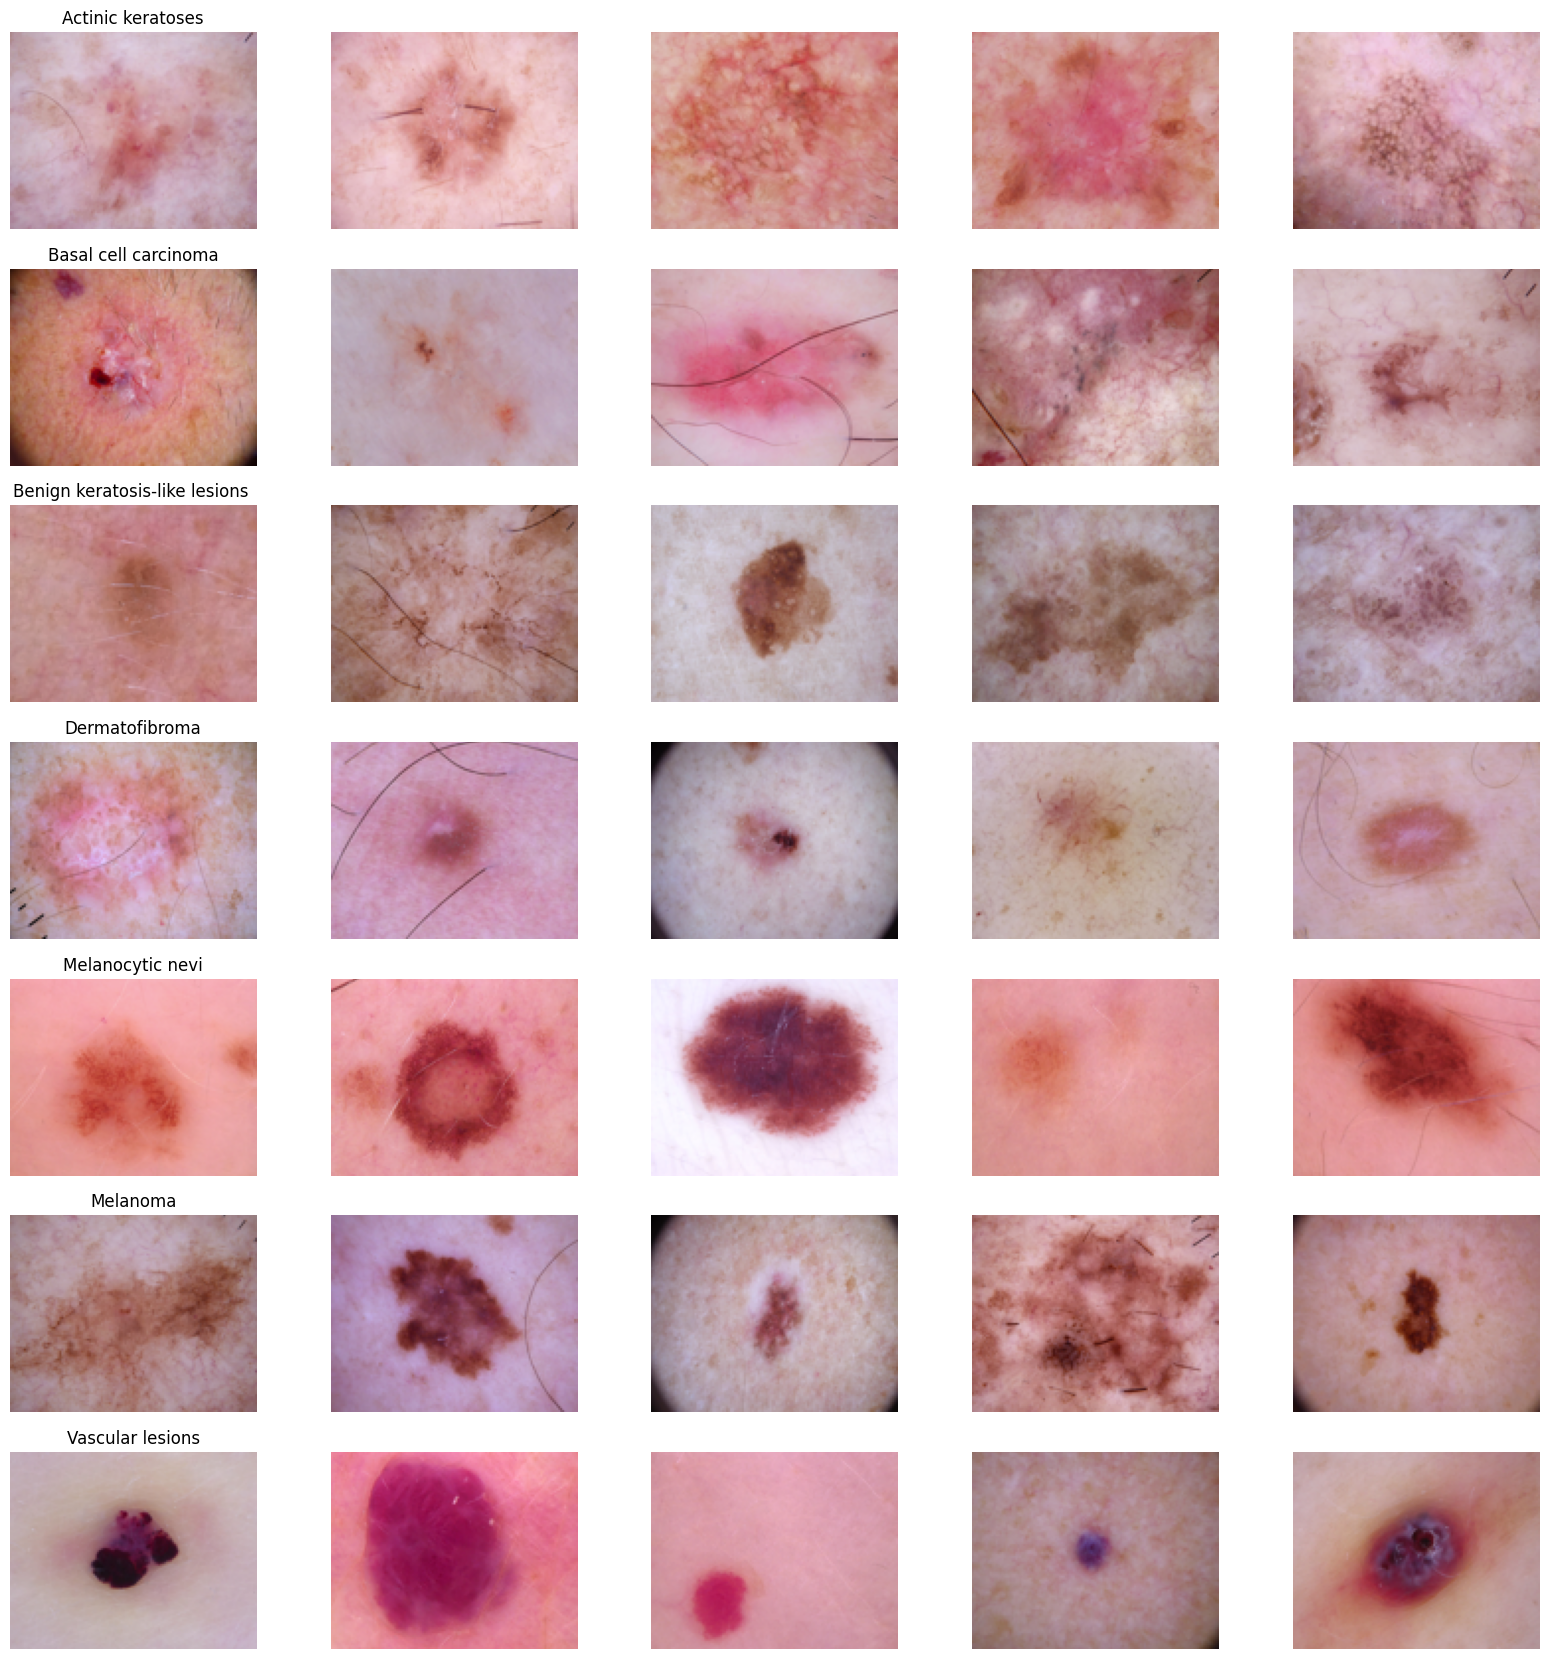

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df_clean.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

## Fixing Data Imbalance

<Axes: title={'center': 'CELL TYPE'}, xlabel='Lesion Type', ylabel='Count'>

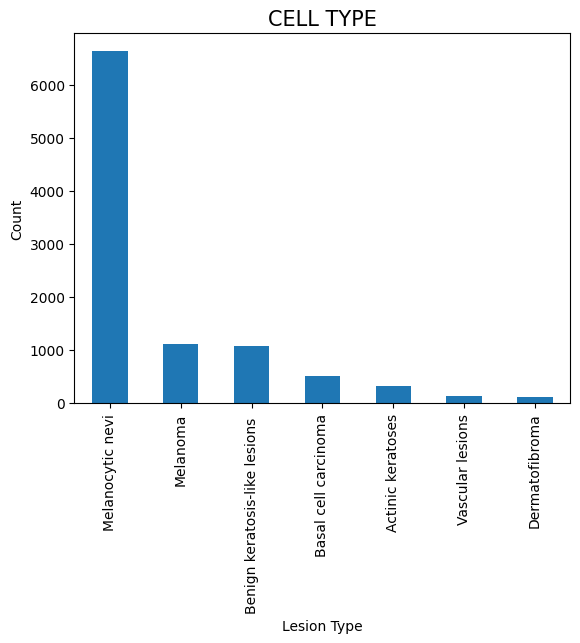

In [ ]:
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
plt.xlabel("Lesion Type")
df_clean['cell_type'].value_counts().plot.bar()

From the distribution above, we can see that the dataset is highly imbalanced. Did not use random oversampling because then then there will be multiple duplicates of the minority class images, which may cause our model to overfit.

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
#Getting our train, test and validation sets

def train_test_df(df):
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']

    #Split train and test 80-20 split used
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

    #We won't normalize right now because we are using GridSearchCV with pipeline
    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())

    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o, num_classes = 7)
    y_test = to_categorical(y_test_o, num_classes = 7)

    #Splitting training into Train and Validatation sets 90-10
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

    #Reshaping the Images into 3 channels (RGB)
    x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
    x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
    x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

    return x_train,x_validate,x_test,y_train,y_validate,y_test

x_train,x_validate,x_test,y_train,y_validate,y_test = train_test_df(df_clean) #change to df_clean

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

## Baseline: Without Data Augmentation



### DenseNet120 Without Data Augmentation

Goal: see the performance of model on non-augmented dataset

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

Epoch 1/50
120/120 [==============================] - 121s 269ms/step - loss: 1.4689 - accuracy: 0.6610 - val_loss: 33929.0977 - val_accuracy: 0.6562 - lr: 0.0100
Epoch 2/50
120/120 [==============================] - 28s 233ms/step - loss: 0.8099 - accuracy: 0.7054 - val_loss: 8.8948 - val_accuracy: 0.6851 - lr: 0.0100
Epoch 3/50
120/120 [==============================] - 28s 236ms/step - loss: 0.7304 - accuracy: 0.7275 - val_loss: 0.9584 - val_accuracy: 0.5516 - lr: 0.0100
Epoch 4/50
120/120 [==============================] - 28s 237ms/step - loss: 0.6936 - accuracy: 0.7432 - val_loss: 1.3250 - val_accuracy: 0.5252 - lr: 0.0099
Epoch 5/50
120/120 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.7410
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004968543536961079.
120/120 [==============================] - 28s 237ms/step - loss: 0.6826 - accuracy: 0.7410 - val_loss: 1.7305 - val_accuracy: 0.4773 - lr: 0.0099
Epoch 6/50
120/120 [=========================

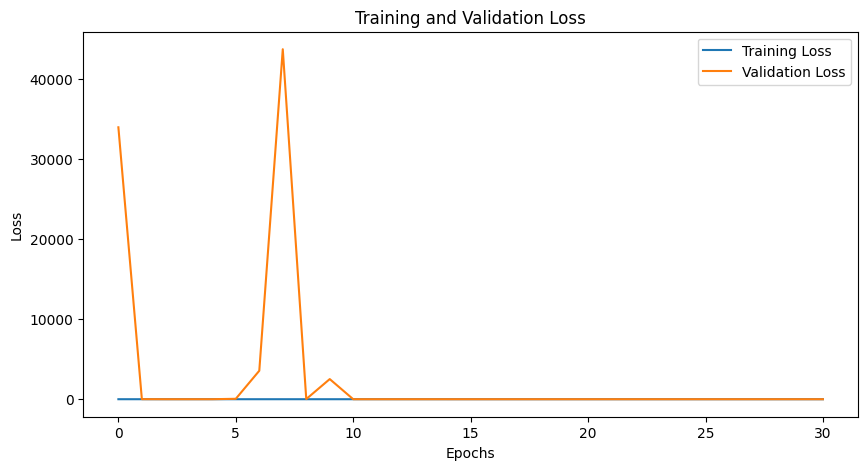

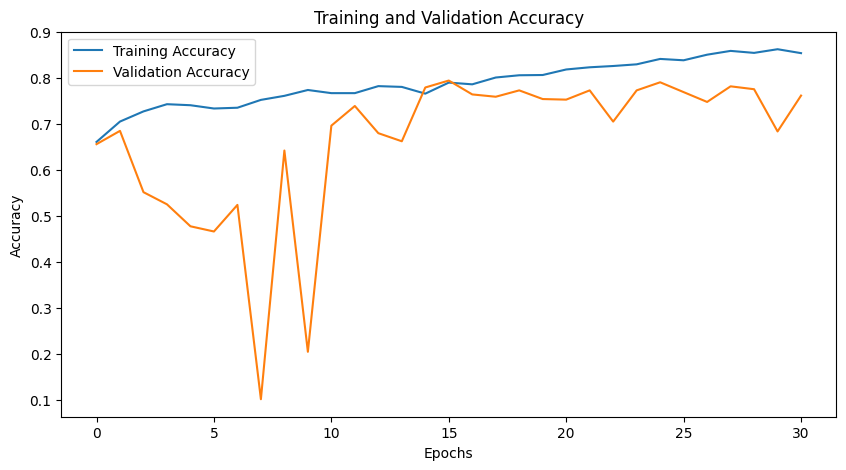

In [ ]:
# Fit the model
epochs = 50
batch_size = 60

history = model_dense.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[learning_rate_reduction, early_stopping],
    validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# Function to plot the confusion matrix with Plotly
import plotly.graph_objects as go

def plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        colorscale = 'Plasma'
    else:
        colorscale = 'Magma_r'  # Reversed 'Magma' colorscale for non-normalized matrix

    annotations = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            annotations.append(
                {
                    'x': classes[j],
                    'y': classes[i],
                    'text': str(cm[i, j]),
                    'showarrow': False,
                    'font': {'color': 'red' if cm[i, j] > 0.5 else 'black'}
                }
            )

    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=list(classes),
        y=list(classes),
        colorscale=colorscale,
        colorbar=dict(title='Normalized' if normalize else 'Count'),
        showscale=True,
        hoverinfo='z'
    ))

    fig.update_layout(
        title='Confusion Matrix',
        xaxis=dict(title='Predicted label'),
        yaxis=dict(title='True label'),
        annotations=annotations
    )

    if normalize:
        fig.update_layout(title_text='Normalized Confusion Matrix')
    else:
        fig.update_layout(title_text='Confusion Matrix (Counts)')

    fig.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201>> : ")
print(report)

63/63 [==============================] - 6s 48ms/step


Classification Report for <<DenseNet201>> : 
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1313
           1       0.66      0.53      0.58       238
           2       0.57      0.50      0.53       222
           3       0.48      0.60      0.53       100
           4       0.39      0.56      0.46        66
           5       0.68      0.79      0.73        24
           6       0.00      0.00      0.00        22

    accuracy                           0.79      1985
   macro avg       0.52      0.56      0.54      1985
weighted avg       0.78      0.79      0.78      1985



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Resnet Without Data Augmentation

## Compared to With Data Augmentation

## Now Introducing with Input Normalization

In [ ]:
#Adding normalization and standardization to train test split

def train_test_df_normstandard(df):
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']

    # Create First Train and Test sets
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())

    #Normalization
    x_train = x_train / 255
    x_test = x_test / 255

    #The standardization is done using the training set Mean and Std. Deviation as reference
    x_train_mean = np.mean(x_train)
    x_train_std = np.std(x_train)

    x_train = (x_train - x_train_mean)/x_train_std
    x_test = (x_test - x_train_mean)/x_train_std

    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o, num_classes = 7)
    y_test = to_categorical(y_test_o, num_classes = 7)

    #Splitting training into Train and Validatation sets
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

    #Reshaping the Images into 3 channels (RGB)
    x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
    x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
    x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

    return x_train,x_validate,x_test,y_train,y_validate,y_test

x_train,x_validate,x_test,y_train,y_validate,y_test = train_test_df_normstandard(df_clean) #change to df_clean

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### DenseNet 201

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

74836368/74836368 [==============================] - 0s 0us/step


<ipython-input-25-1bed1eb40ed0>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - 173s 449ms/step - loss: 1.4512 - accuracy: 0.6655 - val_loss: 24.5792 - val_accuracy: 0.6209 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - 39s 324ms/step - loss: 0.8154 - accuracy: 0.6992 - val_loss: 1.0326 - val_accuracy: 0.6121 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - 40s 337ms/step - loss: 0.7372 - accuracy: 0.7269 - val_loss: 2.1385 - val_accuracy: 0.5176 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - 39s 323ms/step - loss: 0.7595 - accuracy: 0.7378 - val_loss: 20330.0312 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 5/50
119/119 [==============================] - 38s 321ms/step - loss: 0.6893 - accuracy: 0.7528 - val_loss: 16.4408 - val_accuracy: 0.6196 - lr: 0.0099
Epoch 6/50
119/119 [==============================] - 42s 346ms/step - loss: 0.6388 - accuracy: 0.7704 - val_loss: 0.8672 - val_accuracy: 0.6965 - lr: 0.0099
Epoch 7/50
119/119 [=========================

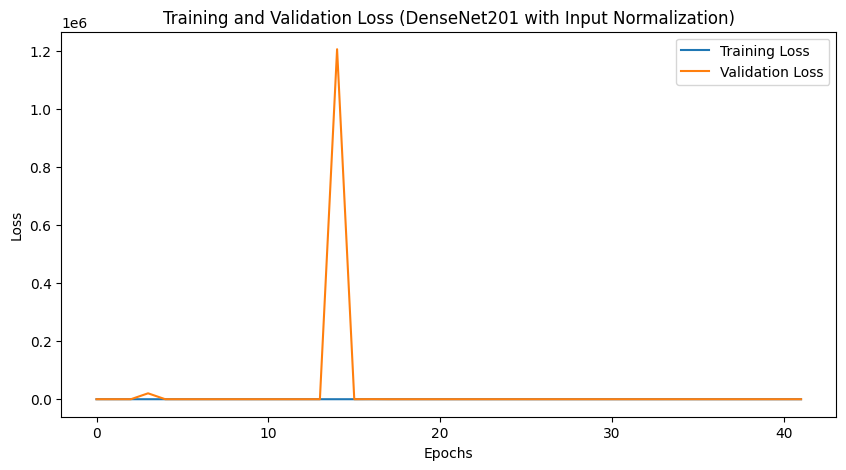

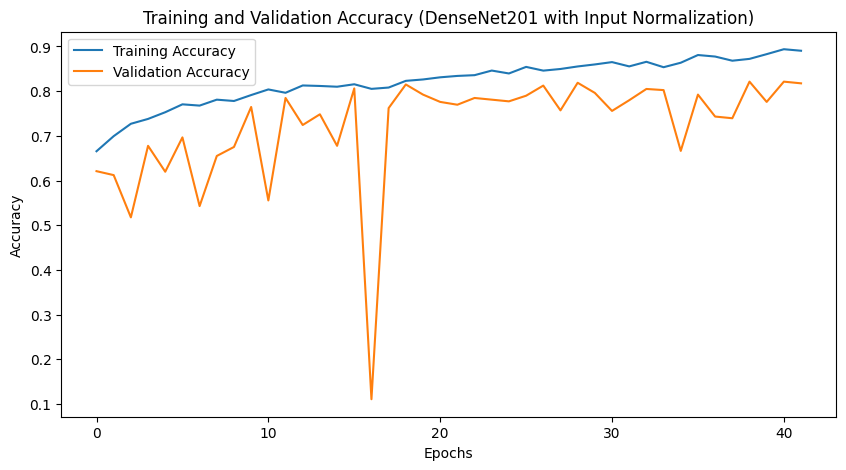

In [ ]:
epochs = 50
batch_size = 60
history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
callbacks=[learning_rate_reduction, early_stopping], validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (DenseNet201 with Input Normalization)')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (DenseNet201 with Input Normalization)')
plt.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201 with Input Normalization>> : ")
print(report)

### ResNet50 with Input Normalization

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_resnet50.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

<ipython-input-17-998e9a8ab13b>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_resnet50.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - 62s 296ms/step - loss: 1.4696 - accuracy: 0.6517 - val_loss: 4309.5703 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - 32s 268ms/step - loss: 0.9411 - accuracy: 0.6745 - val_loss: 8.0739 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - 32s 269ms/step - loss: 0.8851 - accuracy: 0.6908 - val_loss: 1.7008 - val_accuracy: 0.6839 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - 32s 266ms/step - loss: 0.8677 - accuracy: 0.6912 - val_loss: 0.9721 - val_accuracy: 0.6751 - lr: 0.0100
Epoch 5/50
119/119 [==============================] - 32s 272ms/step - loss: 0.8387 - accuracy: 0.6999 - val_loss: 1.9938 - val_accuracy: 0.6877 - lr: 0.0099
Epoch 6/50
119/119 [==============================] - 33s 273ms/step - loss: 0.8351 - accuracy: 0.6977 - val_loss: 3.8289 - val_accuracy: 0.6864 - lr: 0.0099
Epoch 7/50
119/119 [=============================

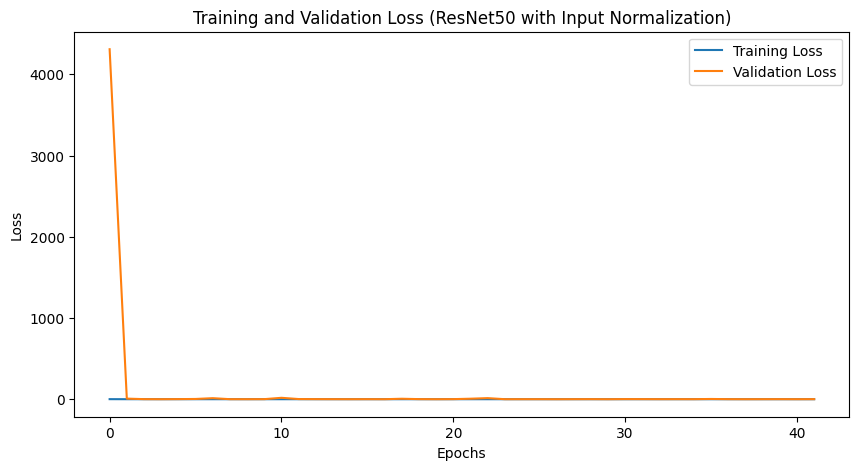

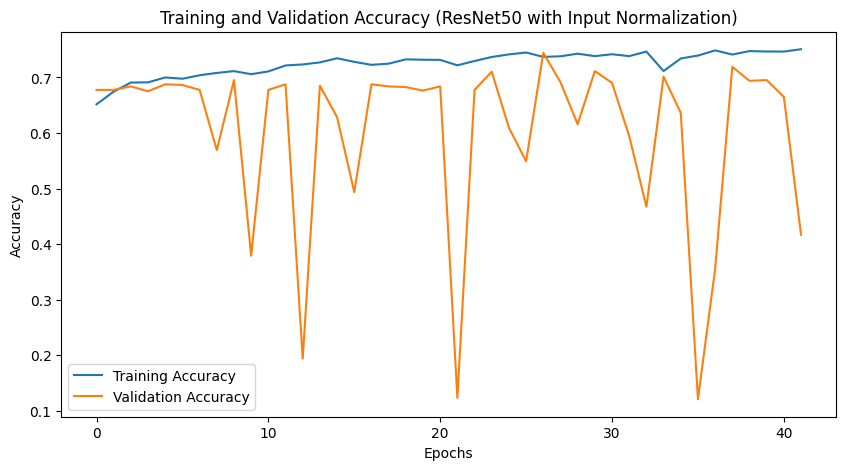

In [ ]:
# Fit the model
epochs = 50
batch_size = 60
history = model_resnet50.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
callbacks=[learning_rate_reduction, early_stopping], validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (ResNet50 with Input Normalization)')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (ResNet50 with Input Normalization)')
plt.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_resnet50.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<ResNet50 with Input Normalization>>: ")
print(report)

63/63 [==============================] - 4s 39ms/step


Classification Report for <<ResNet50 with Input Normalization>>: 
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1313
           1       0.53      0.38      0.44       238
           2       0.45      0.59      0.51       222
           3       0.45      0.52      0.48       100
           4       0.33      0.05      0.08        66
           5       0.91      0.42      0.57        24
           6       0.00      0.00      0.00        22

    accuracy                           0.74      1985
   macro avg       0.50      0.41      0.42      1985
weighted avg       0.72      0.74      0.72      1985



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Introducing Batch Normalization

### DenseNet201 with Batch Norm (Hannah)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

74836368/74836368 [==============================] - 0s 0us/step


<ipython-input-18-6f17e5ccd510>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - 172s 464ms/step - loss: 0.9619 - accuracy: 0.6850 - val_loss: 27.6940 - val_accuracy: 0.0718 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - 39s 323ms/step - loss: 0.7856 - accuracy: 0.7225 - val_loss: 10676402.0000 - val_accuracy: 0.1008 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - 39s 329ms/step - loss: 0.7617 - accuracy: 0.7261 - val_loss: 50.1052 - val_accuracy: 0.0592 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - 43s 358ms/step - loss: 0.6993 - accuracy: 0.7429 - val_loss: 6.9006 - val_accuracy: 0.1851 - lr: 0.0100
Epoch 5/50
119/119 [==============================] - 38s 320ms/step - loss: 0.6996 - accuracy: 0.7471 - val_loss: 1.9110 - val_accuracy: 0.5013 - lr: 0.0099
Epoch 6/50
119/119 [==============================] - 41s 342ms/step - loss: 0.6294 - accuracy: 0.7689 - val_loss: 1.4360 - val_accuracy: 0.5882 - lr: 0.0099
Epoch 7/50
119/119 [======================

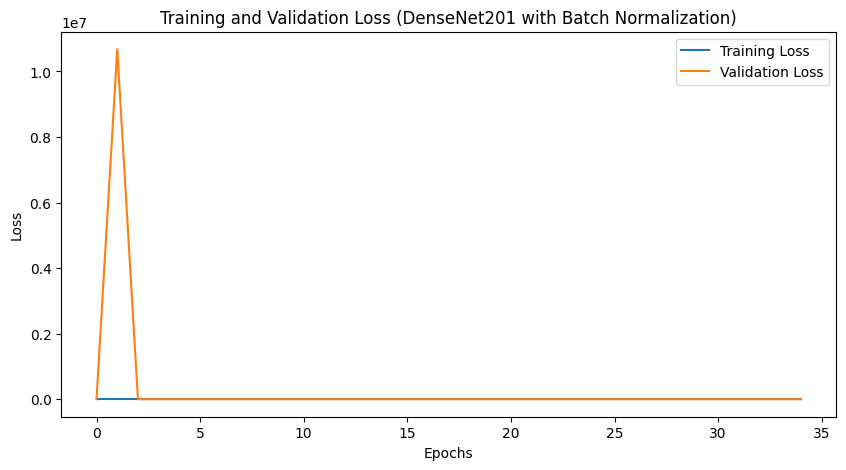

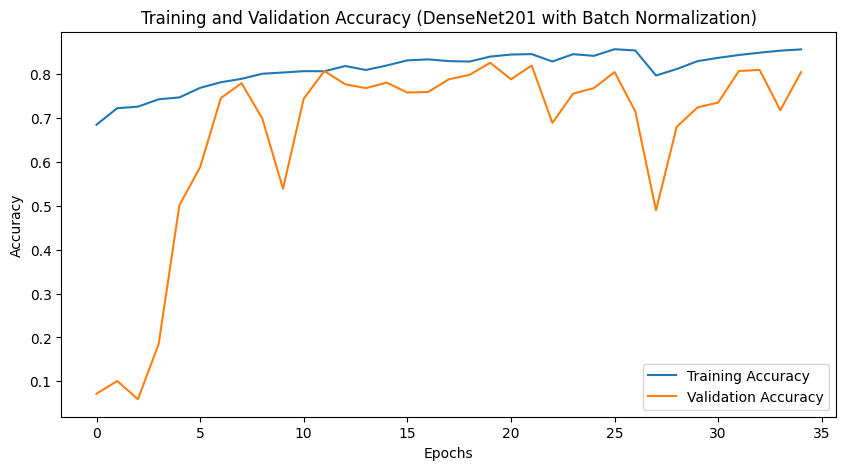

In [ ]:
epochs = 50
batch_size = 60
history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
callbacks=[learning_rate_reduction, early_stopping], validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (DenseNet201 with Batch Normalization)')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (DenseNet201 with Batch Normalization)')
plt.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201 with Batch Normalization>> : ")
print(report)

63/63 [==============================] - 9s 75ms/step


Classification Report for <<DenseNet201 with Batch Normalization>> : 
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1313
           1       0.75      0.37      0.49       238
           2       0.70      0.59      0.64       222
           3       0.67      0.71      0.69       100
           4       0.67      0.24      0.36        66
           5       1.00      0.83      0.91        24
           6       0.67      0.09      0.16        22

    accuracy                           0.81      1985
   macro avg       0.76      0.54      0.59      1985
weighted avg       0.80      0.81      0.79      1985



### ResNet50 with Batch Norm

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Add BatchNormalization layer
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_resnet50.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

<ipython-input-21-38d6e9259646>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_resnet50.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - 63s 280ms/step - loss: 1.2012 - accuracy: 0.6526 - val_loss: 1226748.0000 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - 30s 251ms/step - loss: 1.0796 - accuracy: 0.6704 - val_loss: 57.8518 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - 31s 257ms/step - loss: 1.0321 - accuracy: 0.6761 - val_loss: 2.3814 - val_accuracy: 0.1788 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 0.9324 - accuracy: 0.6874
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004975039046257734.
119/119 [==============================] - 31s 264ms/step - loss: 0.9324 - accuracy: 0.6874 - val_loss: 4.9051 - val_accuracy: 0.0428 - lr: 0.0100
Epoch 5/50
119/119 [==============================] - 31s 261ms/step - loss: 0.8918 - accuracy: 0.6956 - val_loss: 2253.1323 - val_accuracy: 0.6776 - lr: 0.0099
Epoch 6/50
119/119 [====================

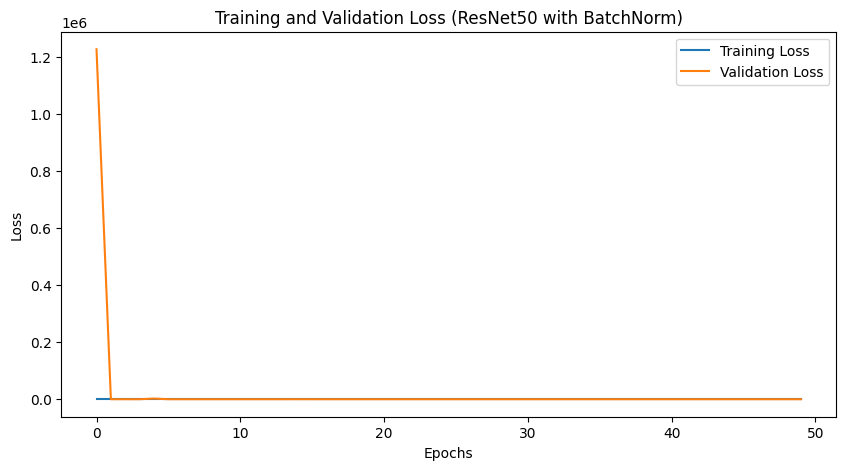

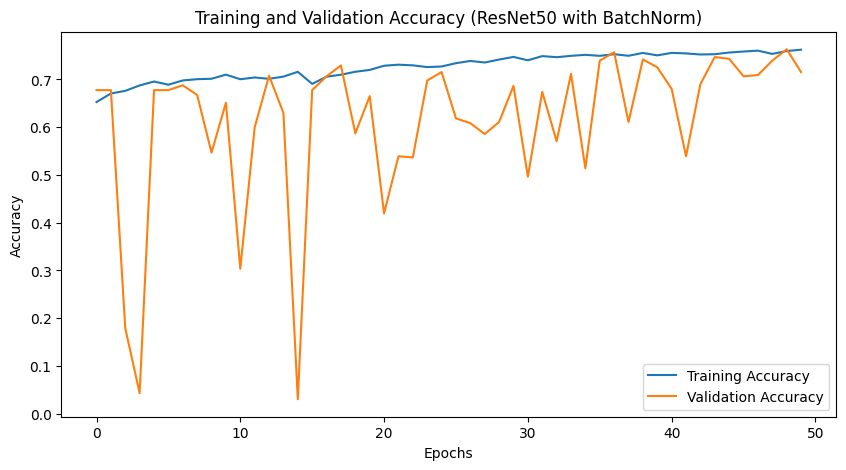

In [ ]:
# Fit the model
epochs = 50
batch_size = 60
history = model_resnet50.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
callbacks=[learning_rate_reduction, early_stopping], validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (ResNet50 with BatchNorm)')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (ResNet50 with BatchNorm)')
plt.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_resnet50.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<ResNet50 with BatchNorm>> : ")
print(report)

63/63 [==============================] - 2s 32ms/step


Classification Report for <<ResNet50 with BatchNorm>> : 
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1313
           1       0.89      0.03      0.06       238
           2       0.33      0.64      0.44       222
           3       0.50      0.02      0.04       100
           4       0.08      0.05      0.06        66
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        22

    accuracy                           0.68      1985
   macro avg       0.37      0.24      0.21      1985
weighted avg       0.70      0.68      0.62      1985



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Build Off and Add Dropout

## Plotting Results (Comparison)

In [ ]:
## Results
classes = [0,1,2,3,4,5,6]
dense_net_baseline = {'precision':[0.90, 0.66, 0.57, 0.48, 0.39, 0.68, 0.00],
                      'recall': [0.92, 0.53, 0.50, 0.60, 0.56, 0.79, 0.00],
                      'f1': [0.91, 0.58, 0.53, 0.53, 0.46, 0.73, 0.00],
                      'accuracy': 0.79,
                      'macro_average_f1': 0.54}

dense_net_aug = {'precision':[0.85, 0.60, 0.59, 0.62, 0.40, 0.83, 0.00],
                      'recall': [0.95, 0.29, 0.58, 0.48, 0.55, 0.79, 0.00],
                      'f1': [0.90, 0.39, 0.58, 0.54, 0.46, 0.81, 0.00],
                      'accuracy': 0.78,
                      'macro_average_f1': 0.53}

dense_net_in = {'precision':[0.94, 0.65, 0.51, 0.72, 0.38, 1.00, 0.50],
                      'recall': [0.89,0.50,0.76,0.60,0.59,0.75,0.36],
                      'f1': [0.91,0.56,0.61,0.66,0.46,0.86,0.42],
                      'accuracy': 0.80,
                      'macro_average_f1': 0.64}

dense_net_bn = {'precision':[0.81, 0.75,0.70,0.67,0.67,1.00, 0.67],
                      'recall': [0.98, 0.37, 0.59, 0.71, 0.24, 0.83, 0.09],
                      'f1': [0.90, 0.49, 0.64, 0.69, 0.36, 0.91, 0.16],
                      'accuracy': 0.81,
                      'macro_average_f1': 0.59}

res_net_base = {'precision':[0.87, 0.56, 0.68, 0.68, 0.42, 0.84, 0.37],
                      'recall': [0.94, 0.52, 0.40, 0.63, 0.53, 0.67, 0.32],
                      'f1': [0.91, 0.54, 0.50, 0.66, 0.47, 0.74, 0.34],
                      'accuracy': 0.79,
                      'macro_average_f1': 0.59}

res_net_aug = {'precision':[0.88, 0.65, 0.67, 0.65, 0.43, 0.78, 0.50],
                      'recall': [0.95, 0.50, 0.62, 0.58, 0.39, 0.75, 0.27],
                      'f1': [0.92, 0.57, 0.65, 0.61, 0.41, 0.77, 0.35],
                      'accuracy': 0.81,
                      'macro_average_f1': 0.61}

res_net_in = {'precision':[0.85, 0.53, 0.45, 0.45, 0.33, 0.91, 0.00],
                      'recall': [0.90, 0.38, 0.59, 0.52, 0.05, 0.42, 0.00],
                      'f1': [0.88, 0.44, 0.51, 0.48, 0.08, 0.57, 0.00],
                      'accuracy': 0.74,
                      'macro_average_f1': 0.42}

res_net_bn = {'precision':[0.79, 0.89, 0.33, 0.50, 0.08, 0.00, 0.00],
                      'recall': [0.91, 0.03, 0.64, 0.02, 0.05, 0.00, 0.00],
                      'f1': [0.85, 0.06, 0.44, 0.04, 0.06, 0.00, 0.00],
                      'accuracy': 0.68,
                      'macro_average_f1': 0.21}


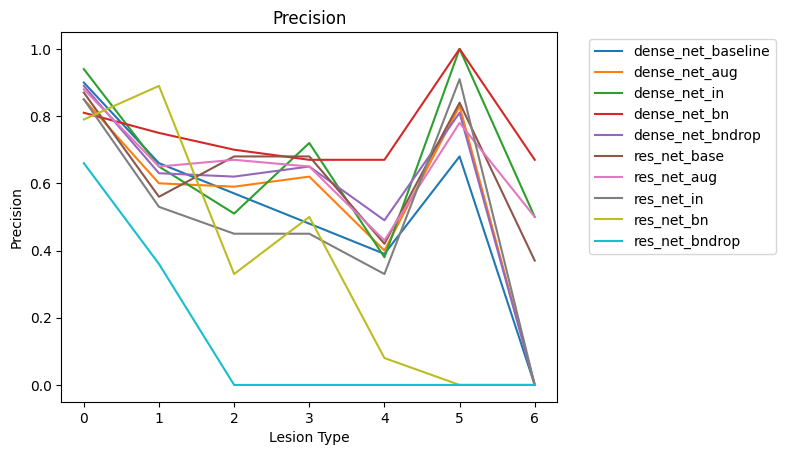

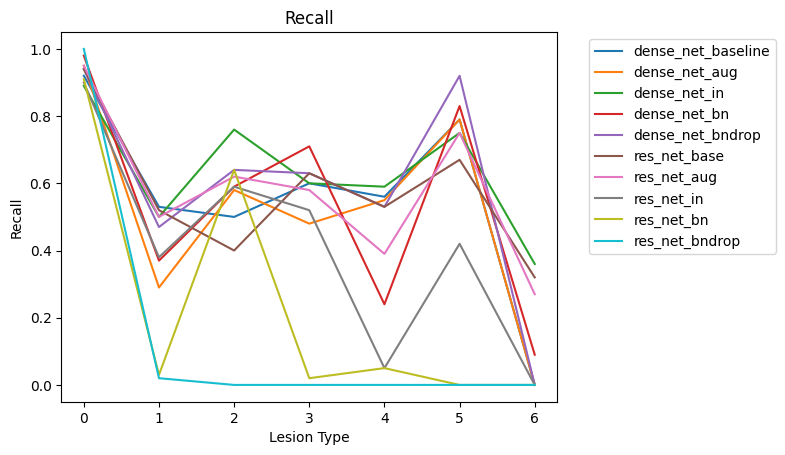

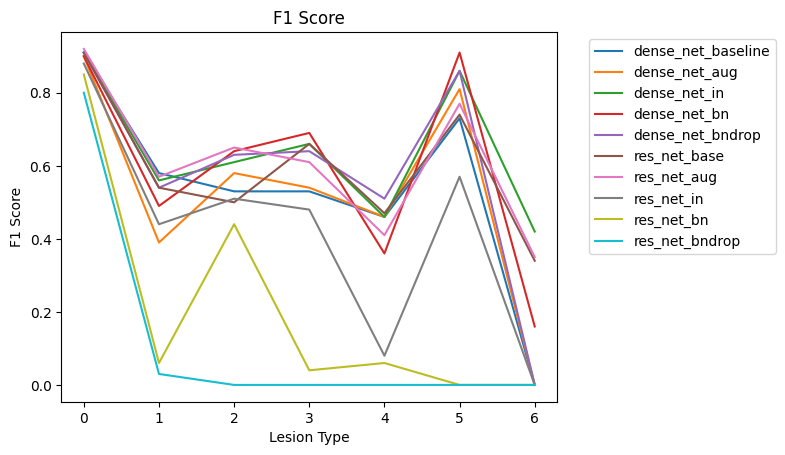

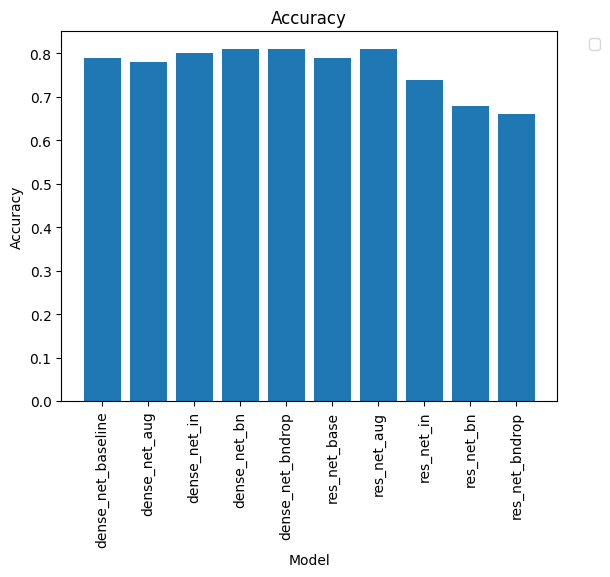

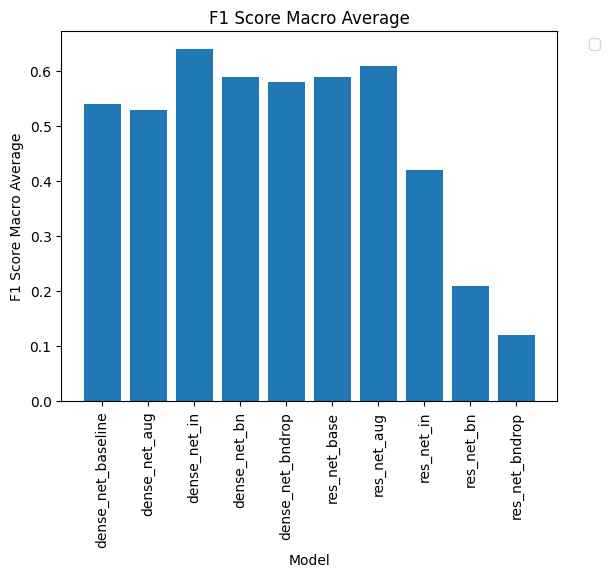

In [ ]:
import matplotlib.pyplot as plt

classes = [0,1,2,3,4,5,6]
# Data for different models
models = ['dense_net_baseline', 'dense_net_aug', 'dense_net_in', 'dense_net_bn', 'dense_net_bndrop', 'res_net_base', 'res_net_aug', 'res_net_in', 'res_net_bn', 'res_net_bndrop']
precision = [[0.90, 0.66, 0.57, 0.48, 0.39, 0.68, 0.00], [0.85, 0.60, 0.59, 0.62, 0.40, 0.83, 0.00], [0.94, 0.65, 0.51, 0.72, 0.38, 1.00, 0.50], [0.81, 0.75, 0.70, 0.67, 0.67, 1.00, 0.67],[0.89, 0.63, 0.62, 0.65, 0.49, 0.81, 0.00], [0.87, 0.56, 0.68, 0.68, 0.42, 0.84, 0.37], [0.88, 0.65, 0.67, 0.65, 0.43, 0.78, 0.50], [0.85, 0.53, 0.45, 0.45, 0.33, 0.91, 0.00], [0.79, 0.89, 0.33, 0.50, 0.08, 0.00, 0.00], [0.66, 0.36, 0.00, 0.00, 0.00, 0.00, 0.00]]
recall = [[0.92, 0.53, 0.50, 0.60, 0.56, 0.79, 0.00], [0.95, 0.29, 0.58, 0.48, 0.55, 0.79, 0.00], [0.89, 0.50, 0.76, 0.60, 0.59, 0.75, 0.36], [0.98, 0.37, 0.59, 0.71, 0.24, 0.83, 0.09],[0.94, 0.47, 0.64, 0.63, 0.53, 0.92, 0.00], [0.94, 0.52, 0.40, 0.63, 0.53, 0.67, 0.32], [0.95, 0.50, 0.62, 0.58, 0.39, 0.75, 0.27], [0.90, 0.38, 0.59, 0.52, 0.05, 0.42, 0.00], [0.91, 0.03, 0.64, 0.02, 0.05, 0.00, 0.00], [1.00, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00]]
f1 = [[0.91, 0.58, 0.53, 0.53, 0.46, 0.73, 0.00], [0.90, 0.39, 0.58, 0.54, 0.46, 0.81, 0.00], [0.91, 0.56, 0.61, 0.66, 0.46, 0.86, 0.42], [0.90, 0.49, 0.64, 0.69, 0.36, 0.91, 0.16], [0.91, 0.54, 0.63, 0.64, 0.51, 0.86, 0.00], [0.91, 0.54, 0.50, 0.66, 0.47, 0.74, 0.34], [0.92, 0.57, 0.65, 0.61, 0.41, 0.77, 0.35], [0.88, 0.44, 0.51, 0.48, 0.08, 0.57, 0.00], [0.85, 0.06, 0.44, 0.04, 0.06, 0.00, 0.00], [0.80, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00]]
accuracy = [0.79, 0.78, 0.80, 0.81, 0.81,  0.79, 0.81, 0.74, 0.68, 0.66]
f1_macro = [0.54, 0.53, 0.64, 0.59, 0.58, 0.59, 0.61, 0.42, 0.21, 0.12]

# Plotting

#Precision Plot
for i in range(len(models)):
  plt.plot(classes, precision[i], label = models[i])

plt.xlabel("Lesion Type")
plt.ylabel("Precision")
plt.title("Precision")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


#Recall Plot
for i in range(len(models)):
  plt.plot(classes, recall[i], label = models[i])

plt.xlabel("Lesion Type")
plt.ylabel("Recall")
plt.title("Recall")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#F1 Score Plot
for i in range(len(models)):
  plt.plot(classes, f1[i], label = models[i])

plt.xlabel("Lesion Type")
plt.ylabel("F1 Score")
plt.title("F1 Score")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#Accuracy Plot
plt.bar(models, accuracy)
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#F1 Macro Average Plot
plt.bar(models, f1_macro)
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("F1 Score Macro Average")
plt.title("F1 Score Macro Average")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


# Ensemble model

### Best DenseNet 201

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
#Checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = "/content/drive/MyDrive/ADS Final Project/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"

#Saves model when the validation accuracy is improving
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
#Compiling model

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

<ipython-input-24-675df03496aa>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.7337
Epoch 1: val_accuracy improved from -inf to 0.66751, saving model to /content/drive/MyDrive/ADS Final Project/model-01-0.6675.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 [==============================] - 119s 799ms/step - loss: 0.7473 - accuracy: 0.7337 - val_loss: 14.4498 - val_accuracy: 0.6675 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.8218 - accuracy: 0.7234
Epoch 2: val_accuracy improved from 0.66751 to 0.69144, saving model to /content/drive/MyDrive/ADS Final Project/model-02-0.6914.hdf5
119/119 [==============================] - 48s 405ms/step - loss: 0.8218 - accuracy: 0.7234 - val_loss: 2.0003 - val_accuracy: 0.6914 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.7673 - accuracy: 0.7344
Epoch 3: val_accuracy did not improve from 0.69144
119/119 [==============================] - 38s 320ms/step - loss: 0.7673 - accuracy: 0.7344 - val_loss: 1.3064 - val_accuracy: 0.4118 - lr: 0.0099
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.7327
Epoch 4: val_accuracy did not improve from 0.69144
119/119 [========================

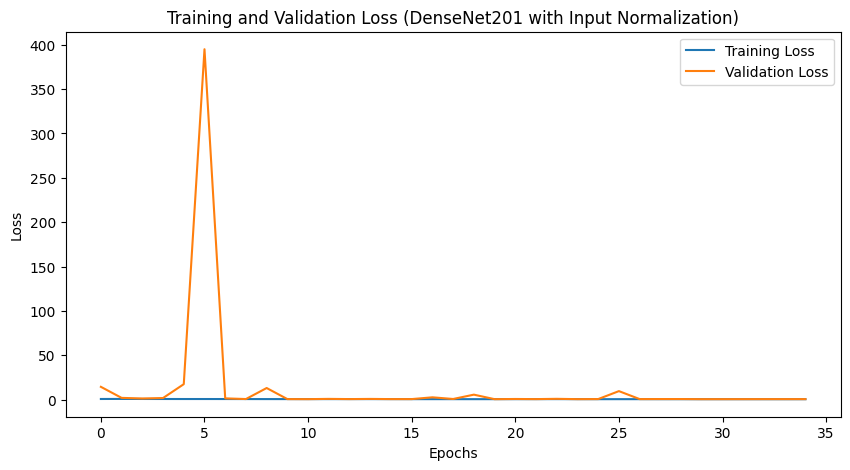

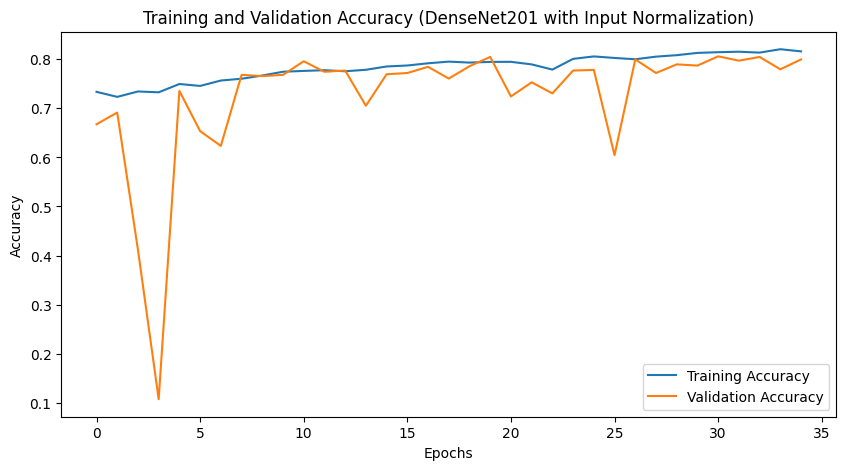

In [ ]:
#Fitting densenet
epochs = 50
batch_size = 60
history1 = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction, early_stopping, checkpoint], validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (DenseNet201 with Input Normalization)')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (DenseNet201 with Input Normalization)')
plt.show()

### ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_resnet50.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

Epoch 1/50


<ipython-input-18-a22458b0a9eb>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model_resnet50.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


119/119 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.7088
Epoch 1: val_accuracy improved from 0.67758 to 0.73804, saving model to /content/drive/MyDrive/ADS Final Project/model-01-0.7380.hdf5
119/119 [==============================] - 31s 261ms/step - loss: 0.8071 - accuracy: 0.7088 - val_loss: 0.8735 - val_accuracy: 0.7380 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.7347
Epoch 2: val_accuracy did not improve from 0.73804
119/119 [==============================] - 30s 249ms/step - loss: 0.7259 - accuracy: 0.7347 - val_loss: 0.7210 - val_accuracy: 0.7305 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7468
Epoch 3: val_accuracy improved from 0.73804 to 0.75819, saving model to /content/drive/MyDrive/ADS Final Project/model-03-0.7582.hdf5
119/119 [==============================] - 32s 265ms/step - loss: 0.6833 - accuracy: 0.7468 - val_loss: 0.6527

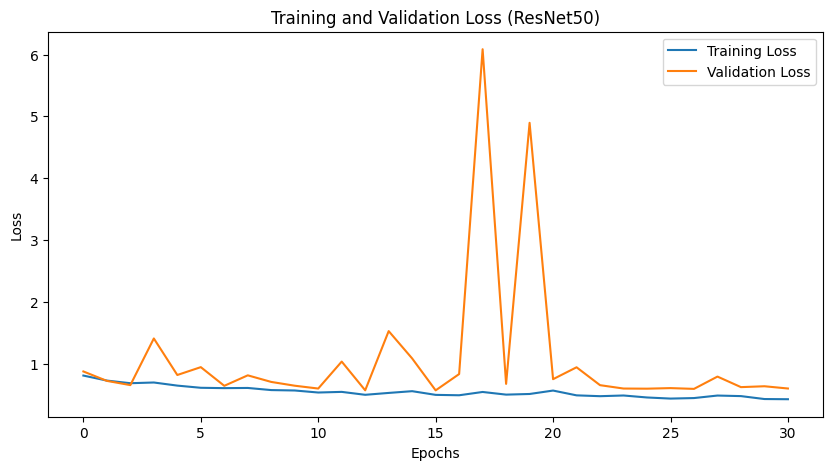

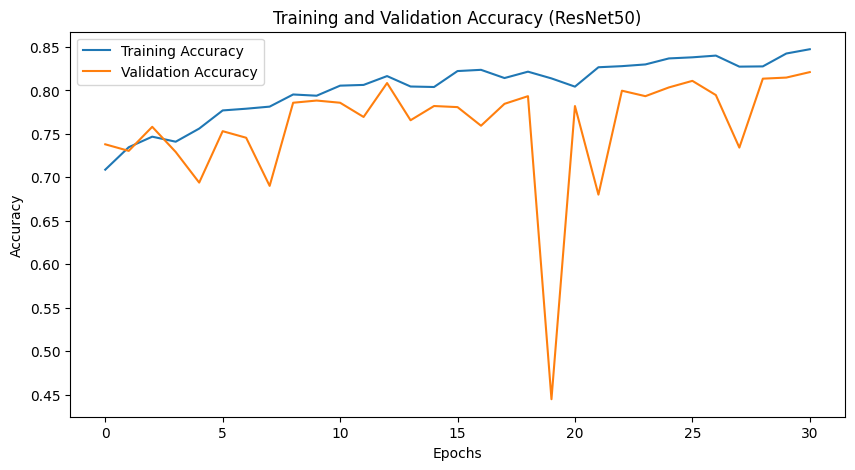

In [ ]:
# Fit the model
epochs = 50
batch_size = 60
history2 = model_resnet50.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
callbacks=[learning_rate_reduction, early_stopping, checkpoint], validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (ResNet50)')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (ResNet50)')
plt.show()

### Combining the 2 models

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

densenet = load_model("/content/drive/MyDrive/ADS Final Project/model-31-0.8060.hdf5") #Change
densenet = Model(inputs = densenet.inputs,
                 outputs = densenet.outputs,
                 name = "dense_net")

resnet = load_model("/content/drive/MyDrive/ADS Final Project/model-31-0.8212.hdf5") #Change
resnet = Model(inputs = resnet.inputs,
                 outputs = resnet.outputs,
                 name = "res_net")

models = [densenet, resnet]
model_input = Input(shape = (100, 125, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs = model_input, outputs = ensemble_output, name = "ensemble")

In [ ]:
ensemble_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

<ipython-input-23-162003c8a6b3>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = ensemble_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - 245s 526ms/step - loss: 0.3992 - accuracy: 0.8574 - val_loss: 0.4620 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/50
119/119 [==============================] - 45s 379ms/step - loss: 0.3784 - accuracy: 0.8663 - val_loss: 0.4592 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 3/50
119/119 [==============================] - 45s 374ms/step - loss: 0.3668 - accuracy: 0.8663 - val_loss: 0.4708 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 4/50
119/119 [==============================] - 44s 371ms/step - loss: 0.3649 - accuracy: 0.8671 - val_loss: 0.4612 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 5/50
119/119 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8702
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
119/119 [==============================] - 44s 368ms/step - loss: 0.3573 - accuracy: 0.8702 - val_loss: 0.4617 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 6/50
119/119 [============================

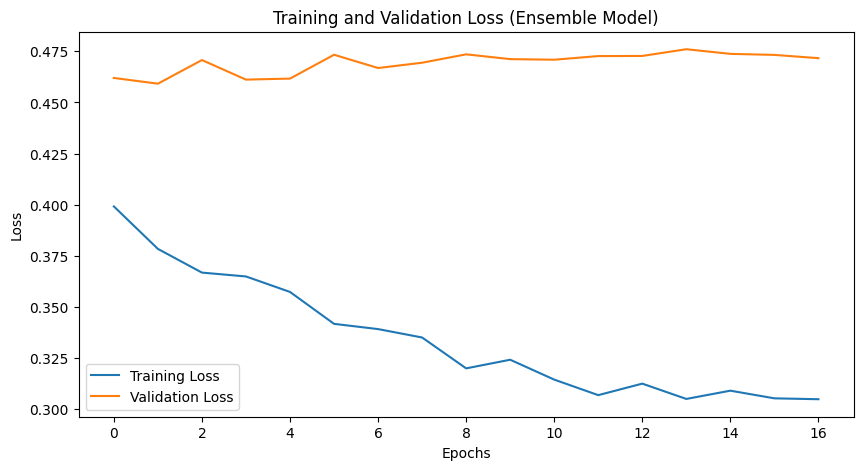

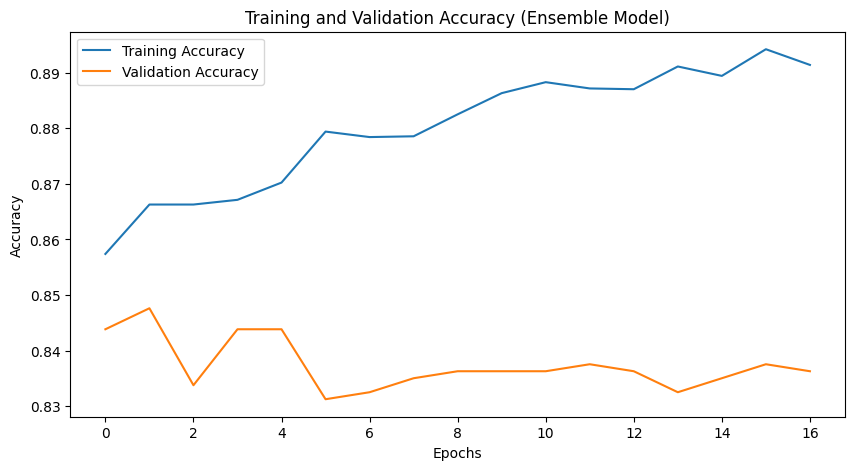

In [ ]:
#Fitting densenet
epochs = 50
batch_size = 60
history1 = ensemble_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction, early_stopping], validation_data=(x_validate, y_validate))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Ensemble Model)')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Ensemble Model)')
plt.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = ensemble_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<Ensemble (ResNet & DenseNet)>>: ")
print(report)

63/63 [==============================] - 4s 71ms/step


Classification Report for <<Ensemble (ResNet & DenseNet)>>: 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1313
           1       0.68      0.58      0.62       238
           2       0.69      0.68      0.69       222
           3       0.78      0.65      0.71       100
           4       0.49      0.35      0.41        66
           5       1.00      0.92      0.96        24
           6       0.56      0.23      0.32        22

    accuracy                           0.83      1985
   macro avg       0.73      0.62      0.66      1985
weighted avg       0.82      0.83      0.83      1985



Reason we are observing a validation loss increase:

This often happens when a model overfits. You may not have enough training data to train such a large model (ResNet50 is huge), causing the model to simply memorize your dataset instead of actually learning to generalize. This is also evident by the training loss going straight to zero. Try a smaller model or more/varied training data. F1 score for class 6 class actually decreases compared to just DenseNet201. Let's see if we can try to improve this.

### Train 4 Different Networks ([0],[1,2],[3,4],[5,6])

In [ ]:
#Build the CNN

import tensorflow as tf

# Define the model using Sequential API
cnn36 = tf.keras.models.Sequential([
    # Convolutional layer 1
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(100, 125, 3)),
    tf.keras.layers.MaxPooling2D((4, 4)),

    # Convolutional layer 2
    tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),

    # Convolutional layer 3
    tf.keras.layers.Conv2D(128, (7, 7), activation='relu'),

    # Convolutional layer 4
    tf.keras.layers.Conv2D(128, (7, 7), activation='relu'),

    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the output for Dense layers
    tf.keras.layers.Flatten(),

    # Dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer with 7 classes and softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
cnn36.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

def train_test_df_normstandard_36(df):
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']
    # Create First Train and Test sets
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)
    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())
    #Normalization
    x_train = x_train / 255
    x_test = x_test / 255
    #The standardization is done using the training set Mean and Std. Deviation as reference
    x_train_mean = np.mean(x_train)
    x_train_std = np.std(x_train)
    x_train = (x_train - x_train_mean)/x_train_std
    x_test = (x_test - x_train_mean)/x_train_std
    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o)
    y_test = to_categorical(y_test_o)
    #Splitting training into Train and Validatation sets
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)
    #Reshaping the Images into 3 channels (RGB)
    x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
    x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
    x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
    return x_train,x_validate,x_test,y_train,y_validate,y_test

In [ ]:
#Subsetting data for 3 and 6 images
# only get data in class 3 or 6
df_36 = df_clean[(df_clean['cell_type_idx'] == 3) | (df_clean['cell_type_idx'] == 6)]
df_36.loc[df_36['cell_type_idx'] == 3, 'cell_type_idx'] = 0
df_36.loc[df_36['cell_type_idx'] == 6, 'cell_type_idx'] = 1
df_36.head()

lesion_id      image_id  dx dx_type   age     sex     localization  \
1095  HAM_0005276  ISIC_0027008  df   histo  75.0    male             back   
1096  HAM_0005276  ISIC_0028790  df   histo  75.0    male             back   
1097  HAM_0004103  ISIC_0028880  df   histo  55.0    male  lower extremity   
1098  HAM_0004103  ISIC_0031309  df   histo  55.0    male  lower extremity   
1099  HAM_0001164  ISIC_0030021  df   histo  50.0  female  upper extremity   

                                                   path       cell_type  \
1095  /content/drive/MyDrive/Study/Year4/Advanced_DS...  Dermatofibroma   
1096  /content/drive/MyDrive/Study/Year4/Advanced_DS...  Dermatofibroma   
1097  /content/drive/MyDrive/Study/Year4/Advanced_DS...  Dermatofibroma   
1098  /content/drive/MyDrive/Study/Year4/Advanced_DS...  Dermatofibroma   
1099  /content/drive/MyDrive/Study/Year4/Advanced_DS...  Dermatofibroma   

      cell_type_idx                                              image  
1095              1  [[[152, 107, 99], [159, 122, 112], [169, 131, ...  
1096              1  [[[207, 158, 164], [210, 161, 167], [216, 165,...  
1097              1  [[[219, 189, 217], [220, 190, 219], [218, 189,...  
1098              1  [[[22, 14, 23], [35, 24, 34], [50, 35, 45], [6...  
1099              1  [[[197, 155, 160], [196, 156, 164], [197, 157,...

In [ ]:
x_train,x_validate,x_test,y_train,y_validate,y_test = train_test_df_normstandard_36(df_36)

In [ ]:
history = cnn36.fit(x_train, y_train, epochs=50,
                    validation_data=(x_validate, y_validate))

Epoch 1/50
15/15 [==============================] - 5s 91ms/step - loss: 0.6667 - accuracy: 0.8164 - val_loss: 0.5812 - val_accuracy: 0.7451
Epoch 2/50
15/15 [==============================] - 0s 18ms/step - loss: 0.4880 - accuracy: 0.8164 - val_loss: 0.6658 - val_accuracy: 0.7451
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 0.4687 - accuracy: 0.8164 - val_loss: 0.5947 - val_accuracy: 0.7451
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.4571 - accuracy: 0.8164 - val_loss: 0.7434 - val_accuracy: 0.7451
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 0.4961 - accuracy: 0.8164 - val_loss: 0.6585 - val_accuracy: 0.7451
Epoch 6/50
15/15 [==============================] - 0s 18ms/step - loss: 0.4499 - accuracy: 0.8164 - val_loss: 0.6117 - val_accuracy: 0.7451
Epoch 7/50
15/15 [==============================] - 0s 18ms/step - loss: 0.4442 - accuracy: 0.8164 - val_loss: 0.7945 - val_accuracy: 0.7451
Epoch 8/50
15

In [ ]:
import plotly.graph_objects as go
def plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        colorscale = 'Plasma'
    else:
        colorscale = 'Magma_r'  # Reversed 'Magma' colorscale for non-normalized matrix

    annotations = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            annotations.append(
                {
                    'x': classes[j],
                    'y': classes[i],
                    'text': str(cm[i, j]),
                    'showarrow': False,
                    'font': {'color': 'green' if cm[i, j] > 0.5 else 'black'}
                }
            )

    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=list(classes),
        y=list(classes),
        colorscale=colorscale,
        colorbar=dict(title='Normalized' if normalize else 'Count'),
        showscale=True,
        hoverinfo='z'
    ))

    fig.update_layout(
        title='Confusion Matrix',
        xaxis=dict(title='Predicted label'),
        yaxis=dict(title='True label'),
        annotations=annotations
    )

    if normalize:
        fig.update_layout(title_text='Normalized Confusion Matrix')
    else:
        fig.update_layout(title_text='Confusion Matrix (Counts)')

    fig.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

classes = range(2)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = cnn36.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for CNN - class 3 and 6 : ")
print(report)

4/4 [==============================] - 0s 7ms/step


Classification Report for CNN - class 3 and 6 : 
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       107
           1       0.47      0.37      0.41        19

    accuracy                           0.84       126
   macro avg       0.68      0.65      0.66       126
weighted avg       0.83      0.84      0.83       126



In [ ]:
#1. Modify training set so only trained on 0 vs Rest (DenseNet201)
  #0 --> is the class
  #Rest --> new model trained on training set grouped (g1 = 1&2), (g2 = 3&4), (g3 = 5&6)
    #G1 --> new model trained on training set with just class 1 and class 2 instances (CNN)
    #G2 --> new model trained on training set with just class 3 and class 4 instances (CNN)
    #G3 --> new model trained on training set with just class 5 and class 6 instances (CNN)

In [ ]:
#solely trained to distinguish between class 1 and 2

In [ ]:
#solely trained to distinguish between class 3 and 4

In [ ]:
#solely trained to distinguish between class 5 and 6